In [283]:
import json

import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.models import load_model
from lime import lime_image
from skimage.segmentation import mark_boundaries

from model.normalization import normalize

In [284]:
MODEL = 'DenseNet'
IMAGE_PATH_COL = 'Image Path'

with open('constant.json', 'r') as const_json:
    const_dict = json.load(const_json)

    MODEL_PATH = "xray_weights_resnet_(7).best.h5"
    IMAGE_SIZE = const_dict['ImageSize']
    LABEL_LIST = const_dict['LabelList']

LABEL_LIST.remove('Mass')
LABEL_LIST.remove('Nodule')
LABEL_LIST.append('Mass / Nodule')

In [285]:
print('loading image...')
img = cv2.imread('archive/images_001/images/00000372_012.png')
print('image loaded.')

print('resizing image...')
img = cv2.resize(img, dsize=IMAGE_SIZE)
print('image resized.')

print('normalizing image...')
img = normalize(img)
print('image normalized.')

print('loading model...')
multi_disease_model = load_model(MODEL_PATH)
print('model loaded.')

loading image...
image loaded.
resizing image...
image resized.
normalizing image...
image normalized.
loading model...
model loaded.


(256, 256, 3)


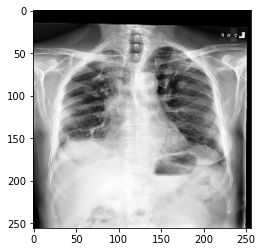

In [286]:
print(img.shape)
plt.imshow(img)

(256, 256, 1)


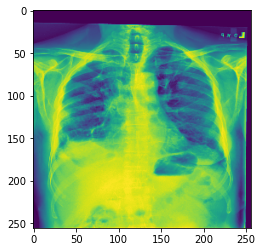

In [287]:
gray_img = []

for i in range(0, IMAGE_SIZE[0]):
    gray_img.append([])

    for j in range(0, IMAGE_SIZE[1]):
        gray_img[i].append([img[i][j][0]])

gray_img = np.array(gray_img)

print(gray_img.shape)
plt.imshow(gray_img)

In [288]:
def grayscale_predict(image):
    image = np.delete(image, (1, 2), axis=3)

    return multi_disease_model.predict(image)


explainer = lime_image.LimeImageExplainer(random_state=7015)
explanation = explainer.explain_instance(img, grayscale_predict)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [289]:
pred = multi_disease_model.predict(np.array([gray_img]))

In [290]:
has_atelectasis = False
has_effusion = False
has_pneumonia = False
has_pneumothorax = False
has_mass_or_nodule = False

if pred[0][0] > 0.35:
    has_atelectasis = True

if pred[0][1] > 0.24:
    has_effusion = True

if pred[0][2] > 0.4:
    has_pneumonia = True

if pred[0][3] > 0.25:
    has_pneumothorax = True

if pred[0][4] > 0.34:
    has_mass_or_nodule = True

In [291]:
if has_atelectasis:
    image, mask = explanation.get_image_and_mask(
        0,
        positive_only=False,
        hide_rest=False,
        num_features=5
    )

    plt.imshow(mark_boundaries(image, mask))

In [292]:
if has_effusion:
    image, mask = explanation.get_image_and_mask(
        1,
        positive_only=False,
        hide_rest=False,
        num_features=5
    )

    plt.imshow(mark_boundaries(image, mask))

In [293]:
if has_pneumonia:
    image, mask = explanation.get_image_and_mask(
        2,
        positive_only=True,
        hide_rest=False
    )

    plt.imshow(mark_boundaries(image, mask))

In [294]:
for i in range(0, len(LABEL_LIST)):
    print(f"{LABEL_LIST[i]}: {pred[0][i]}")

Atelectasis: 0.09926631301641464
Effusion: 0.1661362200975418
Pneumonia: 0.019929595291614532
Pneumothorax: 0.023113291710615158
Mass / Nodule: 0.0659962147474289
